In [1]:
from GDM import Resnet
from GDM import MnistNet

import torch
import torch.nn.functional as F
from torch.autograd import Function
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import copy

transform = transforms.Compose([transforms.ToTensor()])

mnist_test = torchvision.datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

def get_image_by_label(dataset, label):
    for img, target in dataset:
        if target == label:
            return img, target

def add_pixel_pattern(ori_image, poison_patterns):
    image = copy.deepcopy(ori_image)

    for pos in poison_patterns:
        image[0][pos[0]][pos[1]] = 1

    return image


In [4]:
import cv2
import numpy as np

def plot_heatmap(img, heatmap, ax):
    # 调整 heatmap 的大小，匹配原图的尺寸
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # 将 heatmap 归一化到 0 到 255 之间
    heatmap = np.uint8(255 * heatmap)

    # 将 heatmap 应用 JET 颜色映射
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 确保原始的灰度图像 img 是 3 通道
    img = np.uint8(img * 255)  # 先将灰度图像恢复到 0-255 范围
    if len(img.shape) == 2:  # 如果 img 是单通道
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # 将 img 转换为 3 通道

    # 将 heatmap 和原始图像叠加
    superimposed_img = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)

    # 显示叠加后的图像
    ax.imshow(superimposed_img)
    ax.axis('off')


In [5]:
def get_heatmap(model, data, class_idx):
    # 将模型设置为评估模式
    model.eval()

    # 定义 hook 来获取卷积层的输出和梯度
    def forward_hook(module, input, output):
        model.feature_maps = output
    
    def backward_hook(module, grad_in, grad_out):
        model.gradients = grad_out[0]
    
    # 注册 hook，获取 conv2 的输出和梯度
    target_layer = model.conv2
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)
    
    # 前向传播
    data = data.requires_grad_(True)  # 允许计算梯度
    output = model(data)
    
    # 获取目标类别的分数
    score = output[:, class_idx]
    
    # 反向传播以获取梯度
    model.zero_grad()
    score.backward(retain_graph=True)
    
    # 获取卷积层的输出和梯度
    gradients = model.gradients.detach().cpu().numpy()  # [batch_size, num_channels, height, width]
    feature_maps = model.feature_maps.detach().cpu().numpy()  # [batch_size, num_channels, height, width]
    
    # 将梯度在 height 和 width 维度上求平均值，以获得每个通道的权重
    weights = np.mean(gradients, axis=(2, 3))  # 对每个 feature map 的权重，形状是 [num_channels]
    
    # 生成 heatmap，初始化为 0
    heatmap = np.zeros(feature_maps.shape[2:], dtype=np.float32)  # [height, width]

    # 加权求和，将每个权重乘以对应的特征图
    for i, w in enumerate(weights[0]):  # weights[0] 对应的是 batch 的第一个样本
        heatmap += w * feature_maps[0, i, :, :]  # 加权求和
    
    # ReLU 操作，将负值置为0
    heatmap = np.maximum(heatmap, 0)
    
    # 归一化到0-1范围
    heatmap = heatmap / np.max(heatmap) if np.max(heatmap) != 0 else heatmap
    
    return heatmap

In [6]:
def generate_and_plot_heatmaps(model, data, true_label, target_label):
    # 获取对于真实标签和目标标签的heatmap
    true_heatmap = get_heatmap(model, data, true_label)
    target_heatmap = get_heatmap(model, data, target_label)

    # 可视化
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # 将数据从计算图中分离并转换为 NumPy 数组
    axs[0].imshow(data.detach().squeeze().numpy(), cmap='gray')
    plot_heatmap(data.detach().squeeze().numpy(), true_heatmap, axs[0])
    axs[0].set_title(f'Heatmap for true label: {true_label}')

    axs[1].imshow(data.detach().squeeze().numpy(), cmap='gray')
    plot_heatmap(data.detach().squeeze().numpy(), target_heatmap, axs[1])
    axs[1].set_title(f'Heatmap for target label: {target_label}')

    plt.show()


## mnist

In [8]:
global_model = MnistNet.MnistNet()
local1_model = MnistNet.MnistNet()
local2_model = MnistNet.MnistNet()
local3_model = MnistNet.MnistNet()
local4_model = MnistNet.MnistNet()
clean_model = MnistNet.MnistNet()

In [9]:
global_model.load_state_dict(torch.load('models/swift-mnist-1g3l-model.pt', map_location='cpu'))
local1_model.load_state_dict(torch.load('models/swift-mnist-local1-model.pt', map_location='cpu'))
local2_model.load_state_dict(torch.load('models/swift-mnist-local2-model.pt', map_location='cpu'))
local3_model.load_state_dict(torch.load('models/swift-mnist-local3-model.pt', map_location='cpu'))
clean_model.load_state_dict(torch.load('models/swift-mnist-clean-model.pt', map_location='cpu'))

<All keys matched successfully>

In [10]:
image, label = get_image_by_label(mnist_test, 4)
local1 = [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5]]
local2 = [[0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14]]
local3 = [[4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5]]
global_pattern = [ [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5],
            [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14],
            [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5],
            [4, 9], [4, 10], [4, 11], [4, 12], [4, 13], [4, 14]]

image_local1 = add_pixel_pattern(image, local1)
image_local2 = add_pixel_pattern(image, local2)
image_local3 = add_pixel_pattern(image, local3)
image_global = add_pixel_pattern(image, global_pattern)

if len(image.shape) == 3:
    image = image.unsqueeze(0) 
    image_local1 = image_local1.unsqueeze(0)
    image_local2 = image_local2.unsqueeze(0)
    image_local3 = image_local3.unsqueeze(0)
    image_global = image_global.unsqueeze(0)

device = torch.device('cpu')
image = image.to(device)

/Users/bohanliu/Documents/Projects/Federated Learning/DBA-SWIFT/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


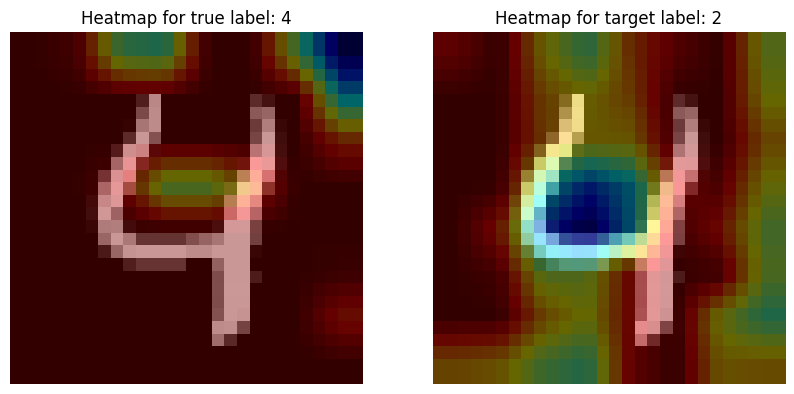

In [11]:
generate_and_plot_heatmaps(clean_model, image, label, 2)

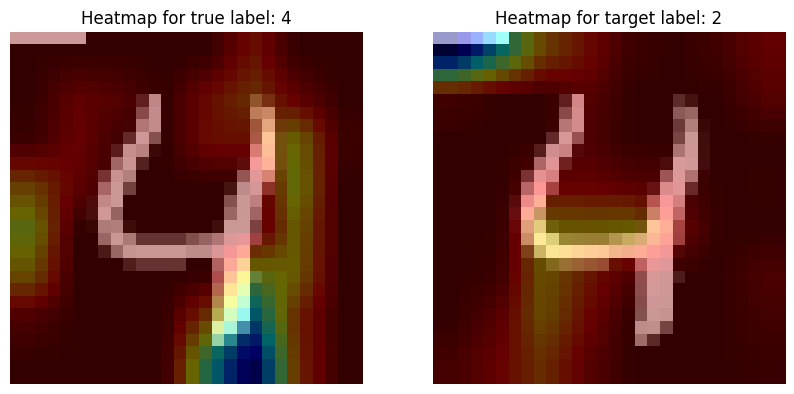

In [12]:
generate_and_plot_heatmaps(local1_model, image_local1, label, 2)

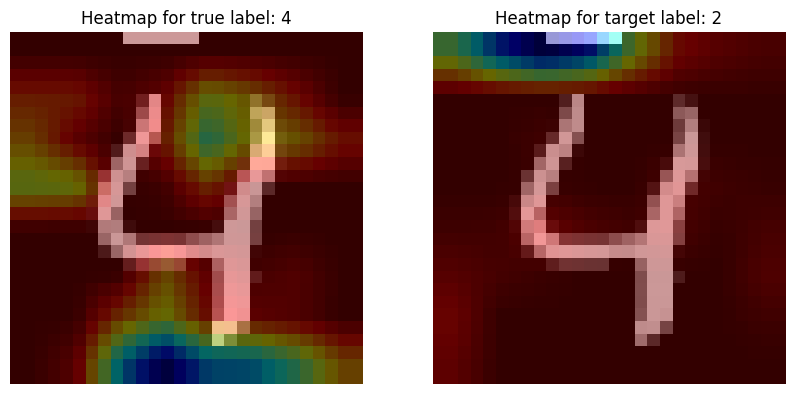

In [13]:
generate_and_plot_heatmaps(local2_model, image_local2, label, 2)

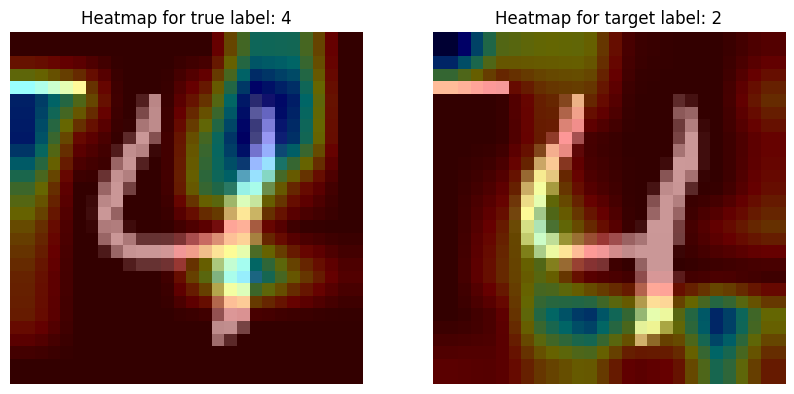

In [14]:
generate_and_plot_heatmaps(local3_model, image_local3, label, 2)

/Users/bohanliu/Documents/Projects/Federated Learning/DBA-SWIFT/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


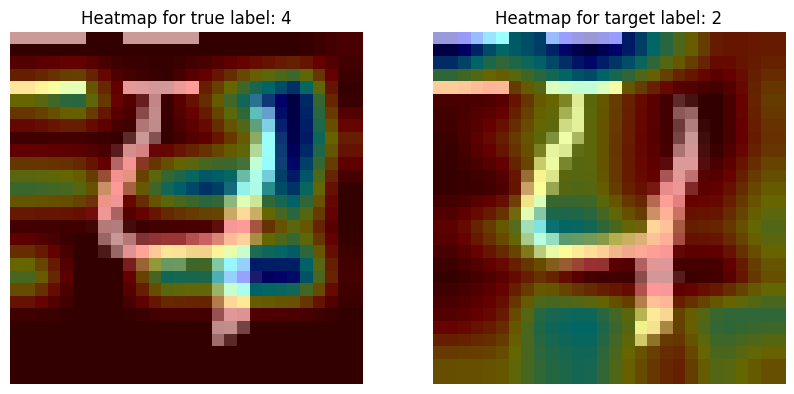

In [15]:
generate_and_plot_heatmaps(global_model, image_global, label, 2)